In [1]:
# I recommend installing Aanaconda3 (64 bit of course) as a "local" install
# don't forget to: pip install pythonnet
# this notebook is run by first opening anaconda prompt and executing: jupyter notebook
# - Michael Folkerts (Michael.Folkerts@varian.com)

In [2]:
import sys
sys.path.append(r'C:\Users\Varian\source\repos\vmspy')  # path to vmspy repo
import pysapi
pysapi.SAFE_MODE = False # bypass C# to Numpy array verification
from matplotlib import pyplot as plt
import numpy as np
from time import time
#load app only once
app = pysapi.CustomScriptExecutable.CreateApplication('python_demo')  # script name is used for logging

In [3]:
patient = app.OpenPatientById('001')

In [4]:
# shortcut for patient.Courses.ElementAt(0).PlanSetups.FirstOrDefault(lambda x: x.Id == '1 IMRT Prost' )
plan = patient.CoursesLot(0).PlanSetupsLot('1 IMRT Prost')

# normal indexing works too
structures = patient.StructureSetsLot()[0].StructuresLot()

# lot.Select takes a function and returns a lot
fem_heads = structures.Select(lambda s: 'fem' in s.Id)
print("Fem Heads:",[(f.Id,f.Volume) for f in fem_heads])

# python.NET treats IEnumerables as an iterable anyway
import pandas as pd
print(
    "Patients:\n",
    pd.DataFrame(
        [(p.Id, p.LastName) for p in app.PatientSummaries],
        columns = ['Id', 'Last Name']
    )[3:13]
)  

body1 = patient.StructureSetsLot()[0].StructuresLot('body')
body = structures['body']  # another shortcut for FirstOrDefault on Id field
assert body == body1  # same object

voxels = plan.StructureSet.Image.voxel_pts_nparray()  # a pysapi extension!

Fem Heads: [('rt fem head', 47.018342511735), ('lt fem head', 46.997995078555086)]
Patients:
      Id Last Name
3   001  IMRT-001
4   002  IMRT-002
5   003  IMRT-003
6   004  IMRT-004
7   005  IMRT-005
8   006  IMRT-006
9   007  IMRT-007
10  008  IMRT-008
11  009  IMRT-009
12  010  IMRT-010


In [5]:
# let's grab some structure masks using pysapi extension method
# this is actually a little slow, but worth the wait... (better impemented in c++ and added to ESAPI)
structures_of_interest = ['PTV 8100','bladder','rectum','body']
masks = {}
tic = time()
for s in structures:
    if s.Id in structures_of_interest:
        print("Creating mask for {}...            ".format(s.Id),end='\r')
        masks[s.Id] = plan.StructureSet.Image.mask_nparray(s)  # pysapi extension!
print("Creating structure masks took {:0.2f} s         ".format(time()-tic))

tic = time()
dose = plan.Dose.nparray_like(plan.StructureSet.Image)  # pysapi extension!
print("Extracting dose took {:0.2f} s".format(time()-tic))

Creating structure masks took 72.84 s         
Extracting dose took 29.55 s


In [6]:
# run some verification based on Structure.IsPointInsideSegment(VVector) ...
# this is very slow!
for sId in structures_of_interest:
    print("Verifying {} mask...".format(sId))
    pysapi.validate_structure_mask(structures[sId],masks[sId],voxels)

Verifying PTV 8100 mask...
mask error (%): 0.0
Verifying bladder mask...
mask error (%): 0.0
Verifying rectum mask...
mask error (%): 0.0
Verifying body mask...
mask error (%): 0.0


(512, 512, 113)


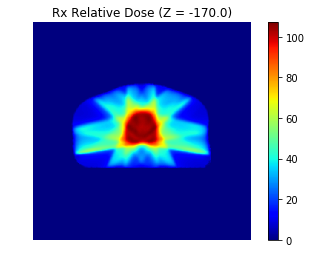

In [7]:
# plot a dose slice ...
assert plan.DoseValuePresentation == pysapi.DoseValuePresentation.Relative, "dose not in relative units"
slice_idx = 39
slice_z_mm = voxels[0,0,slice_idx][2]  # a 3D array of 3D points of locations for each voxel
print(dose.shape)
plt.imshow(dose[:,:,slice_idx].T,interpolation=None,cmap='jet')  # indexed as [x,y,z], transpose needed for imshow
plt.axis('off')
plt.colorbar()
plt.title("Rx Relative Dose (Z = {:.1f})".format(slice_z_mm))
plt.show()

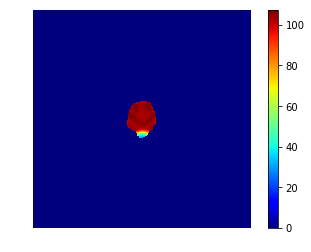

In [8]:
# plot masked dose ...
all_masks = np.zeros_like(masks['body'])
for k,mask in masks.items():
    if k == 'body':
        continue
    all_masks = np.logical_or(all_masks,mask)

plt.imshow((dose*all_masks)[:,:,slice_idx].T,interpolation=None,cmap='jet')  # mask is indexed same as dose grid
plt.axis('off')
plt.colorbar()
plt.title("")
plt.show()

In [ ]:
# let's compute some DVH "by hand" and compare to Eclipse

plt.figure(figsize=(10,7))
for sId in ['PTV 8100','bladder','rectum','body']:
    mask_idx = np.where(masks[sId])
    tot_vox = np.ones_like(dose)[mask_idx].sum()
    hist,bins = np.histogram(dose[mask_idx].flatten(),bins=1000,range=(0,dose.max()))

    plt.plot(bins[:-1],100.-hist.cumsum()*100.0/tot_vox,label=sId)
    dvh = plan.GetDVHCumulativeData(
        structures[sId],
        pysapi.DoseValuePresentation.Relative,
        pysapi.VolumePresentation.Relative,
        .01
    )
    pts = np.array([[p.DoseValue.Dose,p.Volume] for p in dvh.CurveData])
    plt.plot(pts[:,0],pts[:,1],'k--',alpha=.33)

plt.legend(loc=0)
plt.title("Mask-Calculated DVH vs. Eclipse DVH (gray dashed lines)")
plt.show()

In [10]:
# to exit cleanly when done...
app.ClosePatient()
app.Dispose()